In [11]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandarallel import pandarallel
import multiprocessing
pandarallel.initialize(progress_bar=True, nb_workers=multiprocessing.cpu_count())

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [12]:
def break_and_compare(ls, k):
    n = len(ls)
    while n % k != 0:
        n -= 1
    to_break = ls[:n]
    residual = ls[n:]
    chunk_size = n // k
    while len(residual) < chunk_size:
        # split into chunks
        chunks = [to_break[i:i + chunk_size] for i in range(0, len(to_break), chunk_size)]
        chunksMatch = True
        # compare all chunks to first chunk
        for chunk in chunks[1:]:
            if chunk != chunks[0]:
                chunksMatch = False
                break
        if chunksMatch:
            # compare residual to first chunk
            if residual == chunks[0][:len(residual)]:
                return chunks[0]
        chunk_size -= 1
        new_residual = to_break[chunk_size * k:]
        to_break = to_break[:chunk_size * k]
        residual = new_residual + residual
    return []

In [13]:
def break_and_compare_wrapper(ls, start_k, end_k):
    # end_k is inclusive
    ls = list(ls)
    for k in range(start_k, end_k + 1):
        result = break_and_compare(ls, k)
        if result:
            return result, k
    return [], -1

In [14]:
break_and_compare([1,2,3,4,1,2,3,4,1,2,3,4,1], k=3)

[1, 2, 3, 4]

In [15]:
break_and_compare_wrapper([1,2,3,4,1,2,3,4,1,2,3,4,1], start_k=2, end_k=4)

([1, 2, 3, 4], 3)

In [16]:
files = os.listdir('../data')
# choose files without 'lrs' or 'mrs' in the name
files = [file for file in files if 'lrs' not in file and 'mrs' not in file and 'chunk' not in file]
files

['pythia-70m.pkl',
 'pythia-160m.pkl',
 'pythia-410m.pkl',
 'pythia-1b.pkl',
 'pythia-1.4b.pkl',
 'pythia-2.8b.pkl',
 'pythia-6.9b.pkl',
 'pythia-70m-deduped.pkl',
 'pythia-160m-deduped.pkl',
 'pythia-410m-deduped.pkl',
 'pythia-1b-deduped.pkl',
 'pythia-1.4b-deduped.pkl',
 'pythia-2.8b-deduped.pkl',
 'pythia-6.9b-deduped.pkl']

In [17]:
def get_df_with_chunk_and_k(file):
    df = pickle.load(open('../data/' + file, 'rb'))
    df['chunk'], df['k'] = zip(*df['tokens'].parallel_apply(break_and_compare_wrapper, args=(2, 10)))
    # save df as pickle
    pickle.dump(df, open('../data/' + file + "_with_chunk_and_k", 'wb'))
    return df
    

In [18]:
def load_df_with_chunk_and_k(file):
    return pickle.load(open('../data/' + file + "_with_chunk_and_k", 'rb'))

In [20]:
files

['pythia-70m.pkl',
 'pythia-160m.pkl',
 'pythia-410m.pkl',
 'pythia-1b.pkl',
 'pythia-1.4b.pkl',
 'pythia-2.8b.pkl',
 'pythia-6.9b.pkl',
 'pythia-70m-deduped.pkl',
 'pythia-160m-deduped.pkl',
 'pythia-410m-deduped.pkl',
 'pythia-1b-deduped.pkl',
 'pythia-1.4b-deduped.pkl',
 'pythia-2.8b-deduped.pkl',
 'pythia-6.9b-deduped.pkl']

In [24]:
df = load_df_with_chunk_and_k(files[0])

In [33]:
def plot_chunk_length(file):
    df = load_df_with_chunk_and_k(file)
    df_without_k_negative_1 = df[df['k'] != -1]
    # bar plot of df_without_k_negative_1['k'] and save
    plt.figure(figsize=(10, 5))
    sns.countplot(x='k', data=df_without_k_negative_1)
    plt.title('Distribution of k for ' + file)
    plt.savefig('../plots/' + file + '_chunk_length.png')
    # plt.show()

In [34]:
# for file in files:
#     print(file)
#     get_df_with_chunk_and_k(file)

pythia-70m.pkl
pythia-160m.pkl
pythia-410m.pkl
pythia-1b.pkl
pythia-1.4b.pkl
pythia-2.8b.pkl
pythia-6.9b.pkl
pythia-70m-deduped.pkl
pythia-160m-deduped.pkl
pythia-410m-deduped.pkl
pythia-1b-deduped.pkl
pythia-1.4b-deduped.pkl
pythia-2.8b-deduped.pkl
pythia-6.9b-deduped.pkl


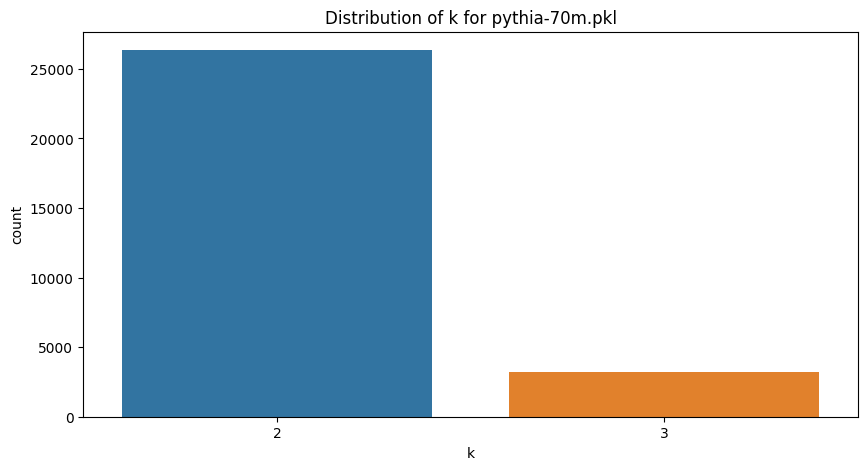

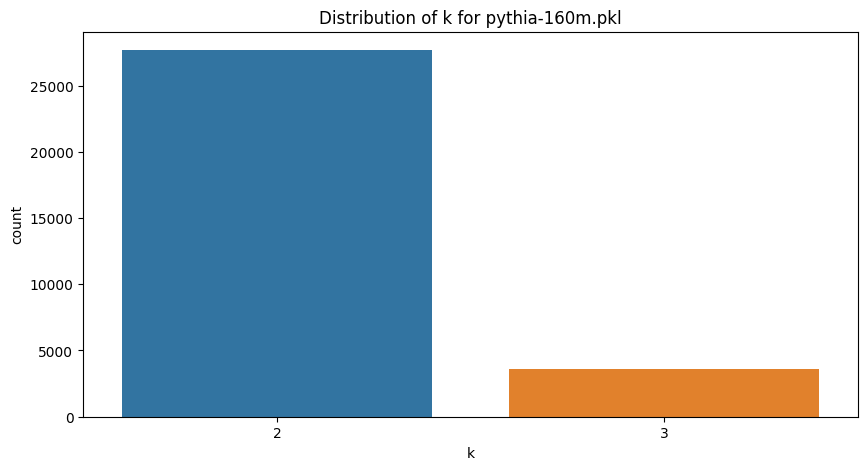

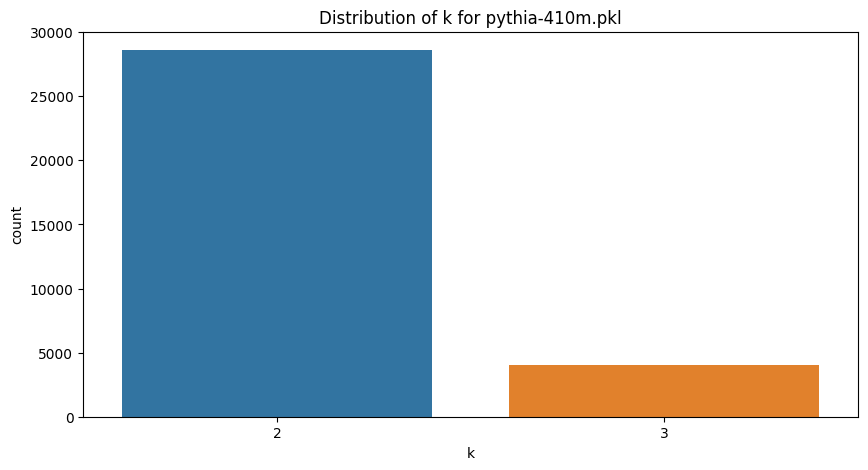

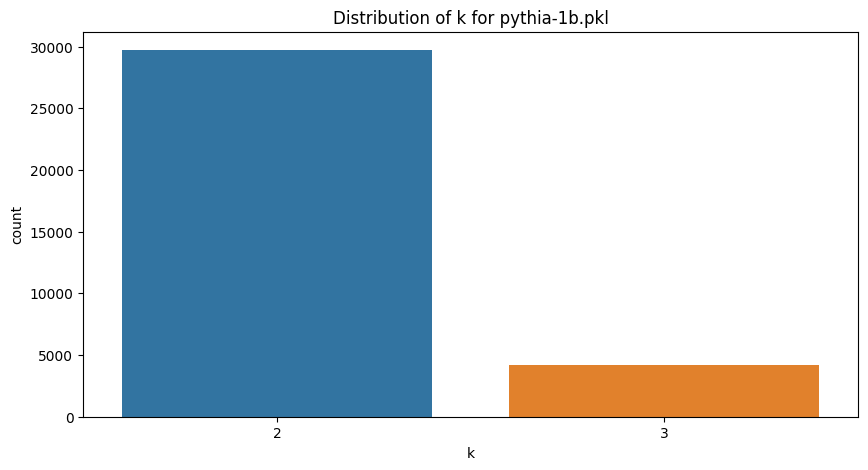

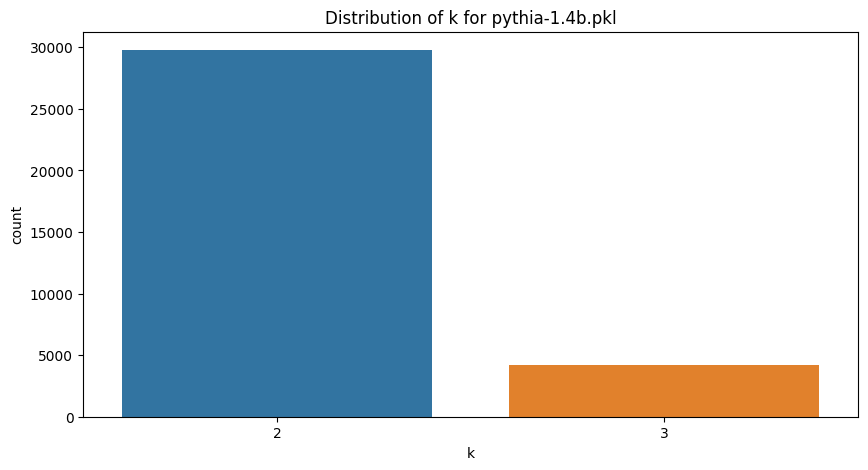

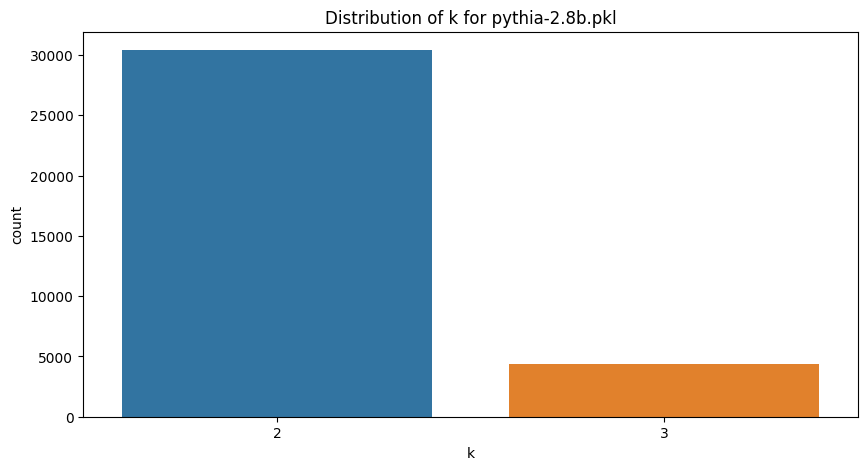

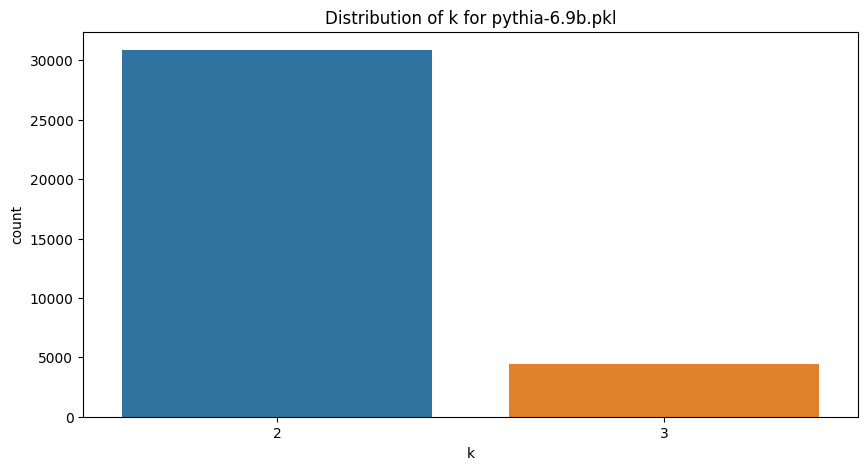

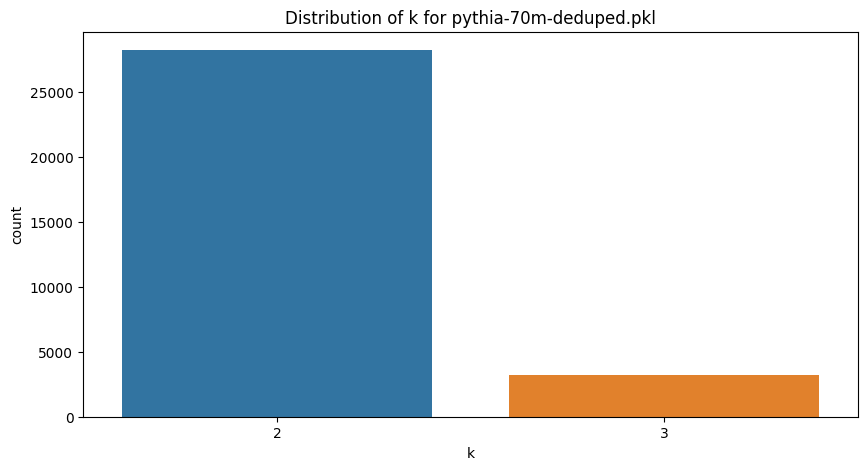

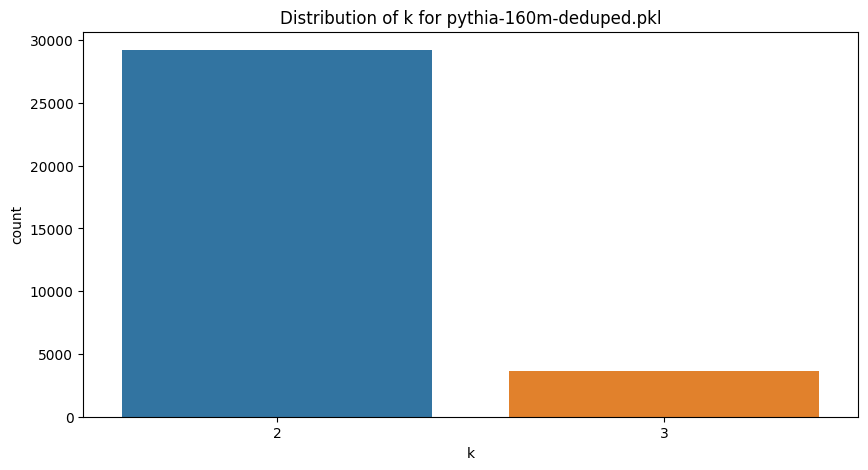

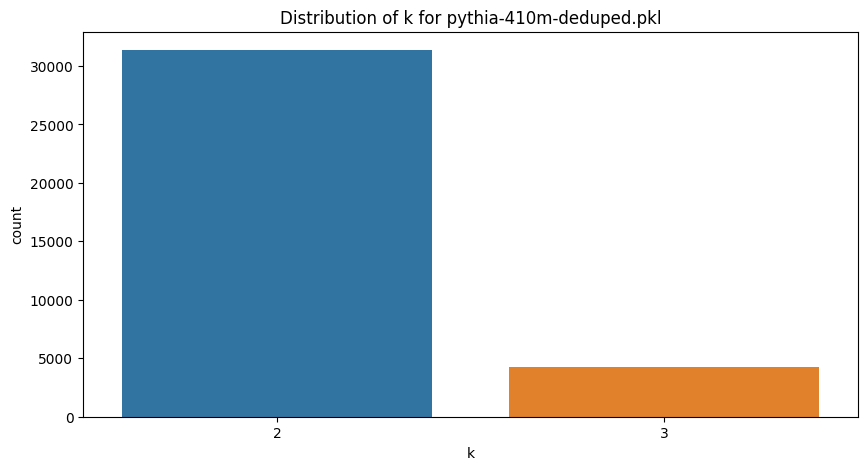

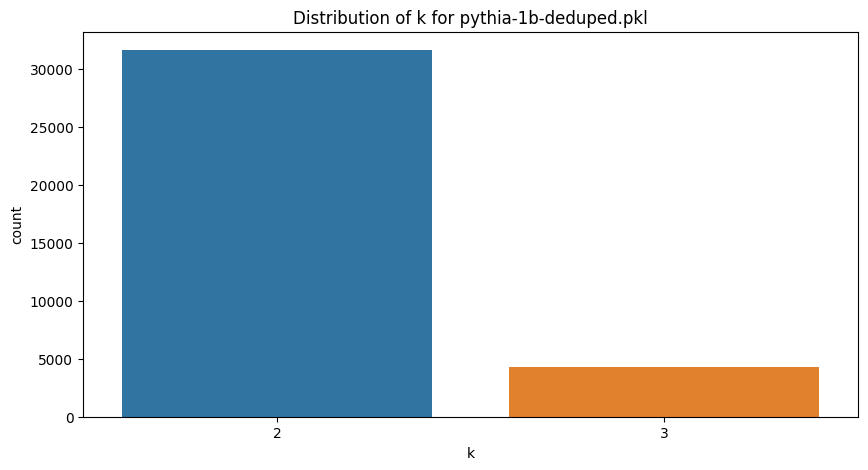

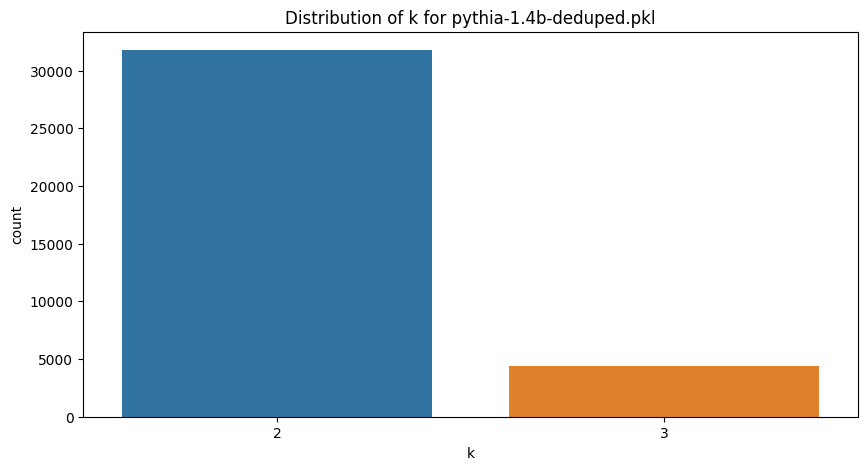

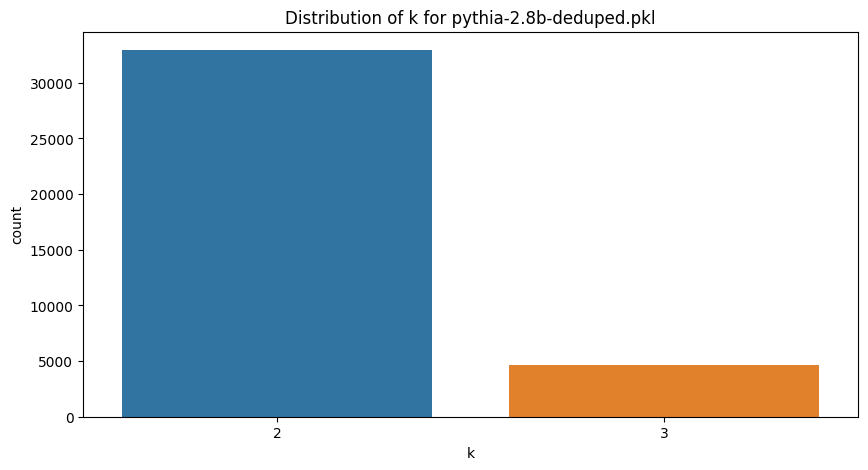

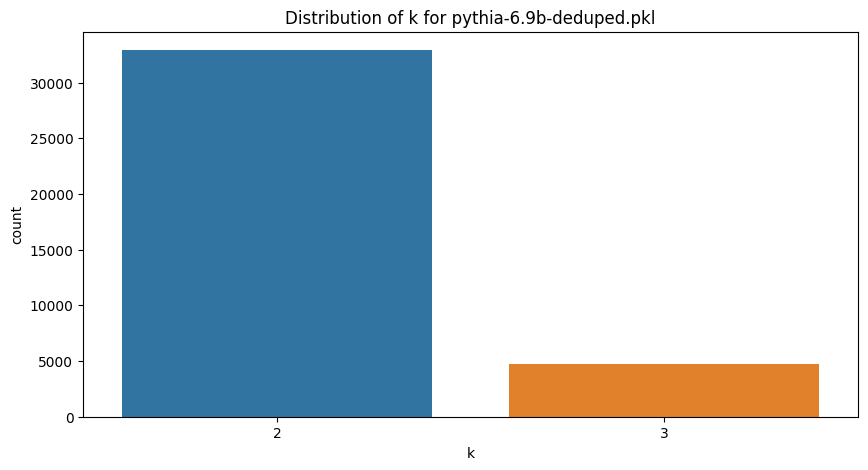

In [35]:
for file in files:
    print(file)
    plot_chunk_length(file)

In [37]:
# Stitch together the plots into a pdf
import glob
from fpdf import FPDF
from PIL import Image

pdf = FPDF()
# imagelist is the list with all image filenames
files = glob.glob('../plots/*.png')
# choose files with lrs in the name
files = [file for file in files if 'chunk_length' in file]
for image in files:
    pdf.add_page()
    pdf.image(image, 0, 0, 210, 297)
pdf.output("../plots/exact_match.pdf", "F")

''